In [220]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

#from qiskit import IBMQ, Aer

In [221]:
def rot_surf_code(n: int) -> QuantumCircuit:              #first ancilla = second last qubit = syndrome/parity measurement qubit, secondt ancilla = last qubit = magic state for T Gate
    qr = QuantumRegister(9*n+2, "q")
    cbit = ClassicalRegister(4,"c")
    qc = QuantumCircuit(qr,cbit)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

def X_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.x(9*n+3)
        circuit.x(9*n+4)
        circuit.x(9*n+5)
    else:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)
    return circuit

def Z_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.z(9*n+1)
        circuit.z(9*n+4)
        circuit.z(9*n+7)
    else:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)
    return circuit

def Hadamard(circuit: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        circuit.h(9*pos+i)
    return circuit

def S_L(circuit: QuantumCircuit, hadamard = False, pos=0):
    for i in range(9):
        circuit.s(9*pos+i)
    qc = Z_L(circuit, hadamard=hadamard, n = pos)
    return qc

def adjoint_S_L(circuit: QuantumCircuit, hadamard = False, pos=0):
    for i in range(9):
        circuit.sdg(9*pos+i)
    qc = Z_L(circuit, hadamard=hadamard, n = pos)
    return qc

def Z_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 2
    if hadamard:
        qc.cx(1+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
    else:
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
    return qc

def X_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 2
    #qc.h(ancilla)
    if hadamard:
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
    else:
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,7+9*pos)
    #qc.h(ancilla)
    return qc

def reset_logical_qubit(qc: QuantumCircuit, pos = 0):
    for i in range(9):
        qc.reset(9*pos+i)
    i = pos
    qc.h(9*i+1)
    qc.h(9*i+3)
    qc.h(9*i+5)
    qc.h(9*i+7)

    qc.cx(9*i+1, 9*i)
    qc.cx(9*i+5, 9*i+4)
    qc.cx(9*i+7, 9*i+8)

    qc.cx(9*i+5, 9*i+2)

    qc.cx(9*i+3, 9*i+4)
    qc.cx(9*i+2, 9*i+1)

    qc.cx(9*i+3,9*i+6)

    qc.cx(9*i+6,9*i+7)
    return qc
    
def T_L(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    magic = qc.num_qubits - 1
    ancilla = qc.num_qubits - 2
    qc.reset(magic)
    qc.reset(ancilla)
    
    qc.h(magic)
    qc.t(magic)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=hadamard, pos = pos)
    qc.cx(magic, ancilla)

    qc.measure(ancilla,0)
    with qc.if_test((0,1)):
        qc = S_L(qc,hadamard=hadamard,pos=pos)
    
    qc.h(magic)
    qc.measure(magic,0)
    with qc.if_test((0,1)):
        qc = Z_L(qc, hadamard=hadamard, n=pos)
    qc.reset(ancilla)
    return qc

def adjoint_T_L(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    magic = qc.num_qubits - 1
    ancilla = qc.num_qubits - 2
    qc.reset(magic)
    qc.reset(ancilla)

    qc.h(magic)
    qc.tdg(magic)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=hadamard, pos = pos)
    qc.cx(magic, ancilla)

    qc.measure(ancilla,0)
    with qc.if_test((0,1)):
        qc = adjoint_S_L(qc,hadamard=hadamard,pos=pos)
    
    qc.h(magic)
    qc.measure(magic,0)
    with qc.if_test((0,1)):
        qc = Z_L(qc, hadamard=hadamard, n=pos)  
    qc.reset(ancilla)
    return qc

def CNOT(circuit:QuantumCircuit, hadamard = "00", control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    if control == 0:
        if hadamard == "10":
            circuit.cx(control_qubit=0,target_qubit=9+6)
            circuit.cx(control_qubit=1,target_qubit=9+3)
            circuit.cx(control_qubit=2,target_qubit=9+0)
            circuit.cx(control_qubit=3,target_qubit=9+7)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+1)
            circuit.cx(control_qubit=6,target_qubit=9+8)
            circuit.cx(control_qubit=7,target_qubit=9+5)
            circuit.cx(control_qubit=8,target_qubit=9+2)
        elif hadamard == "01":
            circuit.cx(control_qubit=0,target_qubit=9+2)
            circuit.cx(control_qubit=1,target_qubit=9+5)
            circuit.cx(control_qubit=2,target_qubit=9+8)
            circuit.cx(control_qubit=3,target_qubit=9+1)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+7)
            circuit.cx(control_qubit=6,target_qubit=9+0)
            circuit.cx(control_qubit=7,target_qubit=9+3)
            circuit.cx(control_qubit=8,target_qubit=9+6)
        else:
            for i in range(9):
                circuit.cx(control_qubit=i,target_qubit=9+i)
    elif control == 1:
        if hadamard == "01":
            circuit.cx(control_qubit=9+0,target_qubit=6)
            circuit.cx(control_qubit=9+1,target_qubit=3)
            circuit.cx(control_qubit=9+2,target_qubit=0)
            circuit.cx(control_qubit=9+3,target_qubit=7)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=1)
            circuit.cx(control_qubit=9+6,target_qubit=8)
            circuit.cx(control_qubit=9+7,target_qubit=5)
            circuit.cx(control_qubit=9+8,target_qubit=2)
        elif hadamard == "10":
            circuit.cx(control_qubit=9+0,target_qubit=2)
            circuit.cx(control_qubit=9+1,target_qubit=5)
            circuit.cx(control_qubit=9+2,target_qubit=8)
            circuit.cx(control_qubit=9+3,target_qubit=1)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=7)
            circuit.cx(control_qubit=9+6,target_qubit=0)
            circuit.cx(control_qubit=9+7,target_qubit=3)
            circuit.cx(control_qubit=9+8,target_qubit=6)
        else: 
            for i in range(9):
                circuit.cx(control_qubit=9+i,target_qubit=i)
    return circuit

def control_S_L(circuit: QuantumCircuit, hadamard = False, control = 0, target = 1):
    qc = circuit
    qc = T_L(qc, hadamard=True, pos=control)
    qc = T_L(qc, hadamard=False, pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    qc = adjoint_T_L(qc,hadamard=False,pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    return qc

def control_Z_L(circuit: QuantumCircuit, hadamard = False, control = 0, target = 1):
    qc = circuit
    qc = Hadamard(qc, pos = target)
    qc = CNOT(qc, False, control = control)
    qc = Hadamard(qc, pos = target)
    return qc

def stabilize(circuit: QuantumCircuit, pos = 0):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    qc = circuit
    
    #X0 X1 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,0+9*pos)
    qc.cx(9+9*pos,1+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,0)
    with qc.if_test((0,1)):
        qc.z(0+9*pos)
    
    #X1 X2 X4 X5 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,1+9*pos)
    qc.cx(9+9*pos,2+9*pos)
    qc.cx(9+9*pos,4+9*pos)
    qc.cx(9+9*pos,5+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,1)

    #X3 X4 X6 X7 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,3+9*pos)
    qc.cx(9+9*pos,4+9*pos)
    qc.cx(9+9*pos,6+9*pos)
    qc.cx(9+9*pos,7+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,2)

    #X7 X8 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,7+9*pos)
    qc.cx(9+9*pos,8+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,3)
    with qc.if_test((3,1)):
        qc.z(7+9*pos)

    with qc.if_test((2,1)) and qc.if_test((1,1)):
        qc.z(4+9*pos)

    with qc.if_test((1,1)) and qc.if_test((2,0)):
        qc.z(2+9*pos)

    with qc.if_test((2,1)) and qc.if_test((1,0)):
        qc.z(3+9*pos)

###########################################################################################################

    #Z3 Z6 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(3+9*pos,9+9*pos)
    qc.cx(6+9*pos,9+9*pos)
    qc.measure(9+9*pos,0)
    with qc.if_test((0,1)):
        qc.x(3+9*pos)

    #Z0 Z1 Z3 Z4 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(0+9*pos,9+9*pos)
    qc.cx(1+9*pos,9+9*pos)
    qc.cx(3+9*pos,9+9*pos)
    qc.cx(4+9*pos,9+9*pos)
    qc.measure(9+9*pos,1)
 
    #Z4 Z5 Z7 Z8 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(4+9*pos,9+9*pos)
    qc.cx(5+9*pos,9+9*pos)
    qc.cx(7+9*pos,9+9*pos)
    qc.cx(8+9*pos,9+9*pos)
    qc.measure(9+9*pos,2)

    #Z2 Z5 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(2+9*pos,9+9*pos)
    qc.cx(5+9*pos,9+9*pos)
    qc.measure(9+9*pos,3)
    with qc.if_test((3,1)):
        qc.x(2+9*pos)
    
    with qc.if_test((2,1)) and qc.if_test((1,1)):
        qc.x(4+9*pos)

    with qc.if_test((1,1)) and qc.if_test((2,0)):
        qc.x(1+9*pos)

    with qc.if_test((2,1)) and qc.if_test((1,0)):
        qc.x(7+9*pos)

    return qc

In [222]:
qc = rot_surf_code(1)               #Logical (adjoint) T scheint NICHT gescheit zu funktionieren!

magic = qc.num_qubits - 1
ancilla = qc.num_qubits - 2

qc = Hadamard(qc,0)

# qc = CNOT(qc,"00",control = 1)          #SWAP Gate
# qc = CNOT(qc,"00",control = 0)

for i in range(4):
    qc = Z_parity(qc, hadamard=False, pos = 0)
    qc.h(magic)
    qc.t(magic)                 #Initialisierung vom Magic State
    qc.cx(magic, ancilla)

    qc.measure(ancilla,0)
    with qc.if_test((0,1)):
        qc = S_L(qc,hadamard=True,pos=0)
        
    qc.h(magic)
    qc.measure(magic,0)
    with qc.if_test((0,1)):
        qc = Z_L(qc, hadamard=True, n=0)
    qc.reset(ancilla)
    qc.reset(magic)

#qc = Hadamard(qc,0)

qc.h(ancilla)

qc = X_parity(qc,True,0)

qc.h(ancilla)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1...: ", counts)

Wir wollen 1...:  {'1001': 45, '1000': 54}


In [223]:
qc = rot_surf_code(2)               #Logische Version vom Controlled S funktioniert net gescheid :/

ancilla = qc.num_qubits - 2

control = 0
target = 1

hadamard = "00"

qc = Hadamard(qc,0)

qc = X_L(qc, False, n = 1)

qc = T_L(qc, hadamard=False, pos=control)
qc = T_L(qc, hadamard=False, pos=target)
qc = CNOT(qc, hadamard=hadamard,control=control)
qc = adjoint_T_L(qc,hadamard=False,pos=target)
qc = CNOT(qc, hadamard=hadamard,control=control)

qc = T_L(qc, hadamard=False, pos=control)
qc = T_L(qc, hadamard=False, pos=target)
qc = CNOT(qc, hadamard=hadamard,control=control)
qc = adjoint_T_L(qc,hadamard=False,pos=target)
qc = CNOT(qc, hadamard=hadamard,control=control)

#qc = control_Z_L(qc, False, 0 , 1)

qc = Hadamard(qc,0)

qc = Z_parity(qc, False, 0)                             #Der zweite logische Qubit wird richtig gemessen (Ohne Hadamards)
qc.measure(ancilla,3)
qc.reset(ancilla)
qc = Z_parity(qc, False, 1)                           #Aber der erste logische Qubit wird nicht richtig gemessen (Mit Hadamards)
qc.measure(ancilla,2)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 1 _ _: ", counts)

Wir wollen 1 1 _ _:  {'1100': 38, '1101': 61}


<BarContainer object of 2 artists>

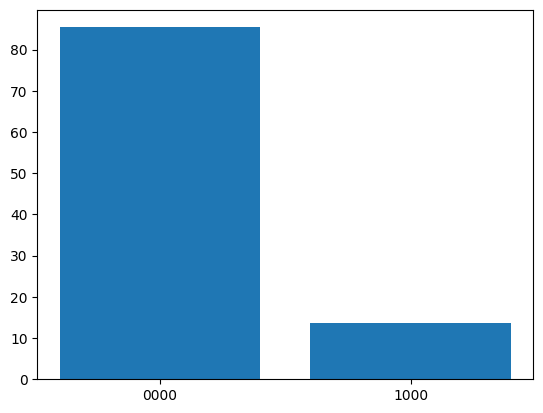

In [224]:
y = [0,0]
x = ["0000","1000"]
mmh = 10

for i in range(mmh):
    qc = rot_surf_code(1)               #Logical (adjoint) T scheint NICHT gescheit zu funktionieren!

    magic = qc.num_qubits - 1
    ancilla = qc.num_qubits - 2


    qc = Hadamard(qc,0)

    # qc = CNOT(qc,"00",control = 1)          #SWAP Gate
    # qc = CNOT(qc,"00",control = 0)
    qc.h(ancilla)

    qc = X_parity(qc, hadamard=True, pos = 0)

    qc.h(magic)
    qc.t(magic)                 #Initialisierung vom Magic State

    qc.cx(ancilla,magic)
    qc.h(ancilla)
    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, shots=99)
    result = job.result()
    counts = result.get_counts()

    y[0] += counts.get("0000")
    y[1] += counts.get("1000")

    #print("Wir wollen 1 _ _ _: ", counts)

y = [i/mmh for i in y]

plt.bar(x,y)

<BarContainer object of 2 artists>

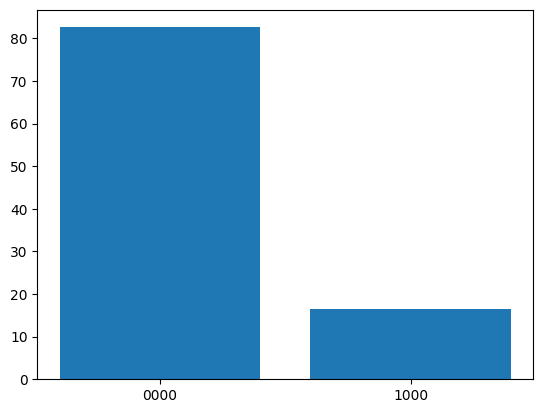

In [225]:
y = [0,0]
x = ["0000","1000"]
mmh = 10

for i in range(mmh):
    qc = rot_surf_code(2)               #Logical (adjoint) T scheint NICHT gescheit zu funktionieren!

    magic = qc.num_qubits - 1
    ancilla = qc.num_qubits - 2

    qc = Hadamard(qc,0)
    qc = Hadamard(qc,1)

    qc = Z_parity(qc, hadamard=False, pos = 0)
    qc.h(magic)
    qc.t(magic)                 #Initialisierung vom Magic State
    qc.cx(magic, ancilla)

    qc.measure(ancilla,0)
    with qc.if_test((0,1)):
        qc = S_L(qc,hadamard=True,pos=0)
        
    qc.h(magic)
    qc.measure(magic,0)
    with qc.if_test((0,1)):
        qc = Z_L(qc, hadamard=True, n=0)
    qc.reset(ancilla)
    qc.reset(magic)

    qc.h(ancilla)

    qc = X_parity(qc,True,0)
    qc = X_parity(qc,True,1)

    qc.h(ancilla)

    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, shots=99)
    result = job.result()
    counts = result.get_counts()

    y[0] += counts.get("0000")
    y[0] += counts.get("0001")
    y[1] += counts.get("1001")
    y[1] += counts.get("1000")

    #print("Wir wollen 1 _ _ _: ", counts)

y = [i/mmh for i in y]
plt.bar(x,y)

In [226]:
qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2
magic = ancilla + 1

qc = Hadamard(qc,0)

qc = CNOT(qc, "00", 0)
qc = CNOT(qc, "00", 1)

qc.h(ancilla)

qc = X_parity(qc, True, 1)

qc.h(magic)

qc.z(magic)

qc.cx(ancilla, magic)

qc.h(ancilla)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}
